# Random forest

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import balanced_accuracy_score, accuracy_score, plot_roc_curve, plot_confusion_matrix
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score
import scipy.sparse as sparse

from matplotlib import pyplot as plt

# Preprocessing

In [2]:
data = pd.read_csv('../data/raw/bank-additional.csv', delimiter=';')
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,...,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no


Удалим столбец duration т.к. он напрямую влияет на предсказанную метку: если продолжительность звонка = 0, то и клиент вклад не оформит

In [3]:
del data["duration"]

In [4]:
le = LabelEncoder()
Y = le.fit_transform(data["y"])

In [5]:
del data["y"]

Выделяем категориальные признаки и присваиваем им числовые значения (всего столбцов теперь 19)

In [6]:
categorical_feature_mask = data.dtypes==object

categorical_cols = data.columns[categorical_feature_mask].tolist()

In [7]:
len(categorical_cols)

10

In [8]:
le = OneHotEncoder()

c = le.fit_transform(data[categorical_cols]).toarray()

for col in categorical_cols:
    del data[col]
for i in range(c.shape[1]):
    data[i] = c[:, i]

In [9]:
data

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,0,...,43,44,45,46,47,48,49,50,51,52
0,30,2,999,0,-1.8,92.893,-46.2,1.313,5099.1,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,39,4,999,0,1.1,93.994,-36.4,4.855,5191.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,25,1,999,0,1.4,94.465,-41.8,4.962,5228.1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,38,3,999,0,1.4,94.465,-41.8,4.959,5228.1,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,47,1,999,0,-0.1,93.200,-42.0,4.191,5195.8,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4114,30,1,999,0,1.4,93.918,-42.7,4.958,5228.1,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4115,39,1,999,0,1.4,93.918,-42.7,4.959,5228.1,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4116,27,2,999,1,-1.8,92.893,-46.2,1.354,5099.1,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4117,58,1,999,0,1.4,93.444,-36.1,4.966,5228.1,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


10 категориальных фичей и 9 числовых

In [10]:
X = data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [11]:
X_train

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,0,...,43,44,45,46,47,48,49,50,51,52
2329,50,5,999,0,1.4,93.444,-36.1,4.965,5228.1,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
121,35,1,999,1,-1.8,92.893,-46.2,1.344,5099.1,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
887,33,5,999,0,1.4,94.465,-41.8,4.961,5228.1,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2937,39,2,999,0,1.1,93.994,-36.4,4.858,5191.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
685,57,4,999,0,-1.8,93.075,-47.1,1.405,5099.1,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3444,60,13,999,0,1.4,93.444,-36.1,4.965,5228.1,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
466,41,1,999,0,-0.1,93.200,-42.0,4.076,5195.8,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3092,27,1,999,0,1.4,93.918,-42.7,4.963,5228.1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3772,34,5,999,0,-1.1,94.199,-37.5,0.879,4963.6,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


По меткам можем наблюдать несбалансированность классов

In [12]:
sum(Y == 1)

451

In [13]:
sum(Y == 0)

3668

In [14]:
int_feature_mask= (X_train.dtypes =='int64')
float_feature_mask= X_train.dtypes == 'float'
categorical_feature_mask = data.dtypes==object

categorical_cols = X_train.columns[categorical_feature_mask].tolist()
float_cols = X_train.columns[float_feature_mask].tolist()
int_cols = X_train.columns[int_feature_mask].tolist()

# Data normalization

Отнормируем числовые данные

In [15]:
scale = StandardScaler()
num_columns = X_train.columns[:9].tolist()

X_train.loc[:, num_columns] = scale.fit_transform(X_train[num_columns] )
X_train

F:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,0,...,43,44,45,46,47,48,49,50,51,52
2329,0.959426,0.961898,0.204739,-0.358359,0.848741,-0.224609,0.939960,0.780592,0.842823,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
121,-0.490698,-0.602426,0.204739,1.423105,-1.188385,-1.170744,-1.244505,-1.305457,-0.902237,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
887,-0.684048,0.961898,0.204739,-0.358359,0.848741,1.528573,-0.292857,0.778288,0.842823,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2937,-0.103998,-0.211345,0.204739,-0.358359,0.657760,0.719808,0.875075,0.718950,0.340949,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
685,1.636151,0.570817,0.204739,-0.358359,-1.188385,-0.858228,-1.439161,-1.270315,-0.902237,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3444,1.926175,4.090545,0.204739,-0.358359,0.848741,-0.224609,0.939960,0.780592,0.842823,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
466,0.089352,-0.602426,0.204739,-0.358359,-0.106162,-0.643587,-0.336114,0.268441,0.405881,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3092,-1.264097,-0.602426,0.204739,-0.358359,0.848741,0.589307,-0.487512,0.779440,0.842823,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3772,-0.587373,0.961898,0.204739,-0.358359,-0.742764,1.071818,0.637163,-1.573343,-2.735227,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [16]:
X_test.loc[:, num_columns] = scale.transform(X_test.iloc[:, :9] )
X_test

F:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,0,...,43,44,45,46,47,48,49,50,51,52
889,0.766076,-0.602426,0.204739,-0.358359,-1.124725,0.776473,0.464136,-1.558940,-2.356454,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2669,-0.490698,-0.602426,0.204739,-0.358359,0.848741,1.528573,-0.292857,0.776560,0.842823,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2707,1.539476,-0.602426,0.204739,1.423105,-0.106162,-0.643587,-0.336114,0.268441,0.405881,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2258,-1.070748,-0.211345,0.204739,-0.358359,-1.888647,-1.050545,-0.076573,-1.353850,-1.212019,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2514,2.119525,-0.211345,0.204739,-0.358359,-1.188385,-1.256600,-2.066383,-1.204064,-0.902237,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
942,1.829500,2.135141,0.204739,-0.358359,0.848741,1.528573,-0.292857,0.777136,0.842823,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2334,-0.877398,0.179736,0.204739,-0.358359,0.848741,0.589307,-0.487512,0.775984,0.842823,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3981,-0.780723,0.961898,0.204739,-0.358359,-1.952307,-1.479826,1.610439,-1.667823,-1.924924,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3477,0.089352,0.179736,0.204739,-0.358359,0.657760,0.719808,0.875075,0.717222,0.340949,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


# Training

Для подбора лучших гиперпараметров пользуемся методом поиска по сетке Gridsearch

In [24]:
%%time
clf = RandomForestClassifier(n_jobs=8)
params = {
    "n_estimators": np.arange(1, 100, 10),
    "max_depth": np.arange(1, 100, 10),
    "min_samples_leaf": np.arange(1, 100, 10),
}
kf = StratifiedKFold(n_splits=5)
clf = GridSearchCV(estimator = clf,
                   param_grid = params, 
                   cv = kf,
                  scoring = "balanced_accuracy")
clf.fit(X_train, y_train)

Wall time: 5min 39s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(n_jobs=8),
             param_grid={'max_depth': array([ 1, 11, 21, 31, 41, 51, 61, 71, 81, 91]),
                         'min_samples_leaf': array([ 1, 11, 21, 31, 41, 51, 61, 71, 81, 91]),
                         'n_estimators': array([ 1, 11, 21, 31, 41, 51, 61, 71, 81, 91])},
             scoring='balanced_accuracy')

In [25]:
print (clf.best_params_, clf.best_score_)

{'max_depth': 21, 'min_samples_leaf': 1, 'n_estimators': 11} 0.635906456154809


Итого получаем:
* Максимальная глубина дерева: 21
* Минимальное кол-во обьектов в листе: 1
* кол-во деревьев: 11

Ниже сравниваем показатели balanced_accuracy_score и accuracy_score. Как и ожидается, balanced_accuracy_score ниже, чем accuracy_score.

In [26]:
%%time
params_ = {
    "n_estimators": 11,
    "max_depth": 21,
    "min_samples_leaf" :1,  
}

clf = RandomForestClassifier(**params_).fit(X_train, y_train)
y_pred = clf.predict(X_test)
print (balanced_accuracy_score(y_test, y_pred), accuracy_score(y_test, y_pred))

0.6084573002754821 0.8904411764705882
Wall time: 37.9 ms


In [32]:
y_pred = clf.predict(X_train)
print (balanced_accuracy_score(y_train, y_pred), accuracy_score(y_train, y_pred))

0.9483015659761738 0.9884015947807177


Посмотрим на другие метрики качества

# Roc curve

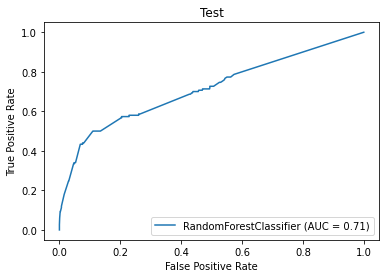

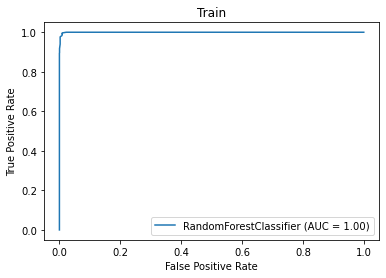

In [27]:
disp1 = plot_roc_curve(clf,X_test, y_test)
disp1.ax_.set_title("Test")
disp2 =plot_roc_curve(clf,X_train, y_train)
disp2.ax_.set_title("Train")
plt.show()

[]

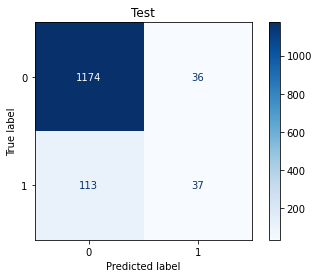

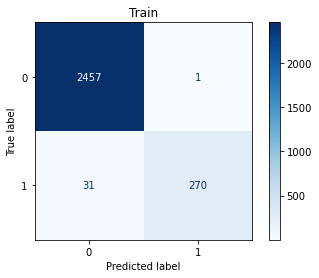

In [28]:
disp1 = plot_confusion_matrix(clf, X_test, y_test,
                                 display_labels=[0,1],
                                 cmap=plt.cm.Blues)
disp1.ax_.set_title("Test")
disp2 = plot_confusion_matrix(clf, X_train, y_train,
                                 display_labels=[0,1],
                                 cmap=plt.cm.Blues)
disp2.ax_.set_title("Train")
plt.plot()

In [29]:
print ("Precision score:", precision_score(y_test, y_pred, average = 'binary'))
print ("Recall score:", recall_score(y_test, y_pred, average = 'binary'))

Precision score: 0.5068493150684932
Recall score: 0.24666666666666667


In [30]:
y_pred = clf.predict(X_train)
print ("Precision score train:", precision_score(y_train, y_pred, average = 'binary'))
print ("Recall score train:", recall_score(y_train, y_pred, average = 'binary'))

Precision score train: 0.996309963099631
Recall score train: 0.8970099667774086


In [34]:
import pickle
pkl_filename = "RandomForest.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(clf, file)